In [2]:
#ipynb config
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.cross_validation import train_test_split
from models.cascade_base import CascadeBase
from visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt

import time

plt.style.use('ggplot')

%matplotlib inline

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [4]:
def iterate_minibatches(inputs, targets, batch_size):
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]

        yield inputs[excerpt], targets[excerpt]
        
        
def downscale(targets, window=20):
    new_shape = targets[0].shape[-1] / window
    results = np.zeros((0, new_shape, new_shape))

    for target in targets:
        result = np.zeros((new_shape, new_shape))
        for xs in range(new_shape):
            for ys in range(new_shape):
                result[xs, ys] = target[xs * window:(xs + 1) * window, ys * window:(ys + 1) * window].max()

        results = np.vstack((results, result.reshape(1, new_shape, new_shape)))

    return results


def learn(nn, dataset, num_epochs=100, batch_size=50):
    '''
        num_epochs - amount of passes through the data
        batch_size - number of samples processed at each function call
        dataset - [X_train, X_val, y_train, y_val]
    '''
    
    X_train, X_val, y_train, y_val = dataset

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_acc = 0
        train_batches = 0
        train_pos_error = 0
        start_time = time.time()

        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_pos_error_batch, train_acc_batch = nn.train(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_pos_error += train_pos_error_batch
            train_batches += 1

        # And a full pass over the validation data:
        val_acc = 0
        val_batches = 0
        val_pos_error = 0

        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_pos_error_batch, val_acc_batch = nn.evaluate(inputs, targets)
            val_acc += val_acc_batch
            val_pos_error += val_pos_error_batch
            val_batches += 1

        # Then we print the results for this epoch:
        print('Epoch {} of {} took {:.3f}s'.format(epoch + 1, num_epochs, time.time() - start_time))
        print('  training loss (in-iteration):\t\t\t{:.6f}'.format(train_err / train_batches))
        print('  train accuracy:\t\t{:.2f} %'.format(train_acc / train_batches * 100))
        print('  train recall:\t\t\t{:.2f} %'.format(train_pos_error / train_batches * 100))
        print('  validation accuracy:\t\t{:.2f} %'.format(val_acc / val_batches * 100))
        print('  validation recall:\t\t{:.2f} %'.format(val_pos_error / val_batches * 100))

In [5]:
dataset = np.load('../data/X.npy')
targets = np.load('../data/targets.npy')

downsampled_answers = downscale(targets.reshape(-1, 200, 200))

X_y = train_test_split(dataset.reshape(-1, 1, 200, 200).astype(np.float32),
                       downsampled_answers.reshape(-1, 1, 10, 10).astype(np.float32))

In [ ]:
network = CascadeBase(img_shape=(200, 200), c=1e-1)
visualizer = Visualizer(network)

In [7]:
learn(network, X_y, num_epochs=100, batch_size=50)

Epoch 1 of 100 took 7.200s
  training loss (in-iteration):			3179.545671
  train accuracy:		80.74 %
  train recall:			8.35 %
  validation accuracy:		84.40 %
  validation recall:		0.00 %
Epoch 2 of 100 took 6.731s
  training loss (in-iteration):			1528.096763
  train accuracy:		84.47 %
  train recall:			0.00 %
  validation accuracy:		84.40 %
  validation recall:		0.00 %
Epoch 3 of 100 took 7.164s
  training loss (in-iteration):			720.705785
  train accuracy:		84.47 %
  train recall:			0.00 %
  validation accuracy:		84.40 %
  validation recall:		0.00 %
Epoch 4 of 100 took 6.677s
  training loss (in-iteration):			400.758221
  train accuracy:		84.47 %
  train recall:			0.00 %
  validation accuracy:		84.40 %
  validation recall:		0.00 %
Epoch 5 of 100 took 6.769s
  training loss (in-iteration):			256.901012
  train accuracy:		84.47 %
  train recall:			0.00 %
  validation accuracy:		84.40 %
  validation recall:		0.00 %
Epoch 6 of 100 took 6.764s
  training loss (in-iteration):			179.688084
 

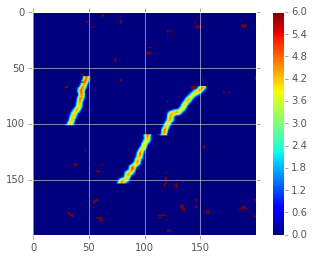

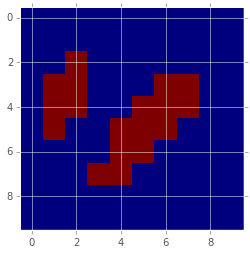

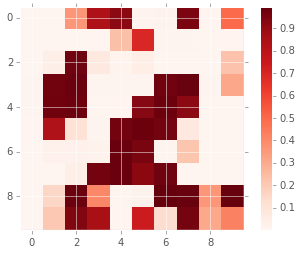

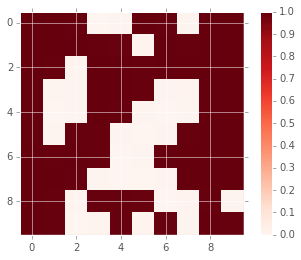

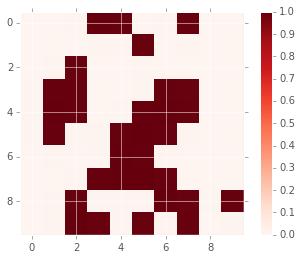

In [36]:
i = 2

plt.imshow(X_y[1][i].reshape((200, 200)))
plt.colorbar()
plt.show()

plt.imshow(X_y[-1][i].reshape((10, 10)), interpolation='none')
plt.show()

prediction = network.predict(X_y[1][i].reshape((1, 1, 200, 200)).astype(np.float32))

plt.imshow(prediction.reshape(10, 10), interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) < 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()

plt.imshow(prediction.reshape(10, 10) >= 0.5, interpolation='none', cmap=plt.cm.Reds)
plt.colorbar()
plt.show()